This notebools is based on the following paper:

>**The tricellular vertex-specific adhesion molecule Sidekick facilitates polarised cell intercalation during Drosophila axis extension** _Tara M Finegan, Nathan Hervieux, Alexander Nestor-Bergmann, Alexander G. Fletcher, Guy B Blanchard, Benedicte Sanson_ bioRxiv 704932; doi: https://doi.org/10.1101/704932 

In particular, the authors expose a nice way to account for rosettes and solve topology changes in a more generic and I think robust way than T1 transition. I think, it allows vertices with more than 3 out-edges to have a finite lifetime, and avoids T1 oscillations


I explore its implementation in [tyssue](https://github.com/damcb/tyssue), in 2D (also maybe in 3D, though it's less clear how :p).

In [ ]:
# % conda install -c conda-forge tyssue

In [1]:
import numpy as np
import pandas as pd
import ipyvolume as ipv

import matplotlib.pylab as plt
%matplotlib inline


from tyssue import config
from tyssue import Monolayer, Sheet
from tyssue import PlanarGeometry as geom
from tyssue.generation import extrude
from tyssue.dynamics import model_factory, effectors
from tyssue.solvers.quasistatic import QSSolver

from tyssue.topology import remove_face, close_face
from tyssue.draw import sheet_view, highlight_cells


### Create a small patch of cells in 2D and a simple mechanical model

In [2]:
sheet = Sheet.planar_sheet_2d('flat', 30, 30, 1, 1, noise=0.2)
to_cut = sheet.cut_out([(0.1, 6), (0.1, 6)])
sheet.remove(to_cut, trim_borders=True)
sheet.sanitize(trim_borders=True)
geom.center(sheet)
geom.update_all(sheet)
model = model_factory(
    [
        effectors.LineTension,
        effectors.FaceContractility,
        effectors.FaceAreaElasticity
    ]
)

specs = {
    "face": {
        "contractility": 5e-2,
        "prefered_area": sheet.face_df.area.mean(),
        "area_elasticity": 1.
    },
    "edge": {
        "line_tension": 1e-2,
        "is_active": 1
    },
    "vert": {
        "is_active": 1
    },
}

sheet.update_specs(specs, reset=True)

Reseting column is_active of the vert dataset with new specs


### Gradient descent

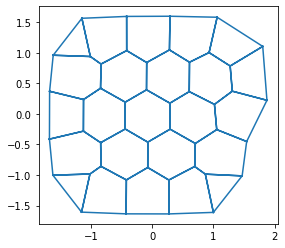

In [4]:
solver = QSSolver()

res = solver.find_energy_min(sheet, geom, model)

fig, ax = sheet_view(sheet, mode="quick")


## Formation of rosettes

<hr/>

![first screencap, forming rosettes](../data/png/finegan_etal_screencap1.png)

_Finegan et al. 2019_

In [5]:
# first let's get vertex ranks
# Note that this is 2 for border edges, might cause problems...
sheet.vert_df['rank'] = sheet.edge_df.groupby('srce').size()

### Merge vertices

In [6]:
def merge_vertices(sheet, edge):
    srce, trgt = sheet.edge_df.loc[edge, ['srce', 'trgt']]
    sheet.vert_df.loc[srce, sheet.coords] = sheet.vert_df.loc[
        [srce, trgt], sheet.coords].mean(axis=0)
    sheet.vert_df.drop(trgt, axis=0, inplace=True)
    # rewire
    sheet.edge_df.replace({"srce": trgt, "trgt": trgt}, srce, inplace=True)
    # all the edges parallel to the original
    collapsed = sheet.edge_df.query("srce == trgt")
    sheet.edge_df.drop(collapsed.index, axis=0, inplace=True)
    sheet.reset_index()
    sheet.reset_topo()
    sheet.vert_df['rank'] = sheet.edge_df.groupby('srce').size()

    

Maximum vertex rank:  4


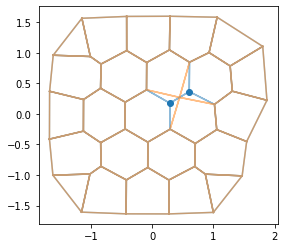

In [7]:
fig, ax = sheet_view(sheet, mode="quick", edge={"alpha": 0.5})
center_edge = sheet.edge_df.eval("sx**2 + sy**2").idxmin()
ax.scatter(sheet.edge_df.loc[center_edge, ["sx", "tx"]],
           sheet.edge_df.loc[center_edge, ["sy", "ty"]])

merge_vertices(sheet, center_edge)
geom.update_all(sheet)
fig, ax = sheet_view(sheet, mode="quick", ax=ax, edge={"alpha": 0.5})

print("Maximum vertex rank: ", sheet.vert_df['rank'].max())

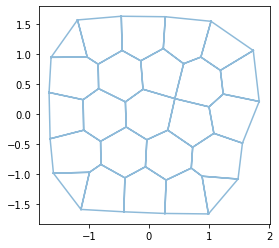

In [8]:
res = solver.find_energy_min(sheet, geom, model)
fig, ax = sheet_view(sheet, mode="quick", edge={"alpha": 0.5})


### Do it again to increase rank

Maximum vertex rank:  6


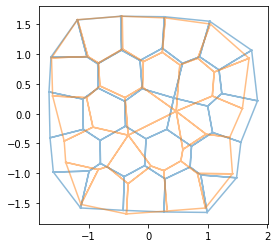

In [9]:
fig, ax = sheet_view(sheet, mode="quick", edge={"alpha": 0.5})

for i in range(4):
    center_edge = sheet.edge_df.eval("sx**2 + sy**2").idxmin()
    merge_vertices(sheet, center_edge)
    geom.update_all(sheet)
    res = solver.find_energy_min(sheet, geom, model)
    
fig, ax = sheet_view(sheet, mode="quick", ax=ax, edge={"alpha": 0.5})


print("Maximum vertex rank: ", sheet.vert_df['rank'].max())

## Rosettes resolution

<hr/>

![Second screencap, solving rosettes](../data/png/finegan_etal_screencap2.png)

_Finegan et al. 2019_



As far as I understand, the difference between rank 5+ and rank 4 is not topological, but geometrical (the "old" vertex is moved towards the opposite cell center) and statistical because $p_4$ is higher than $p_{5+}$

In [10]:



def split_vert(sheet, vert, epsilon=0.1):
    
    out_edges = sheet.edge_df.query(f"srce == {vert}")
    edge = np.random.choice(out_edges.index)
    face = out_edges.loc[edge, 'face']
    face_edges = sheet.edge_df.query(f"face == {face}")
    prev_v, = face_edges[face_edges["trgt"] == vert]["srce"]
    next_v, = face_edges[face_edges["srce"] == vert]["trgt"]

    # Add a vertex
    sheet.vert_df = sheet.vert_df.append(
        sheet.vert_df.loc[vert], ignore_index=True)
    new_vert = sheet.vert_df.index[-1]
    
    # Move it towards the face center
    r_ia = (sheet.face_df.loc[face, sheet.coords] - sheet.vert_df.loc[vert, sheet.coords])
    sheet.vert_df.loc[new_vert, sheet.coords] += r_ia * epsilon / np.linalg.norm(r_ia)
    
    # rewire
    connected = sheet.edge_df[
        sheet.edge_df[["srce", "trgt"]]
        .isin([prev_v, next_v])
        .sum(axis=1)
        .astype(bool)
    ]
    
    sheet.edge_df.loc[connected.index] = connected.replace(
        {"srce": vert, "trgt": vert}, new_vert
    )
    for face in connected["face"]:
        close_face(sheet, face)

    sheet.reset_index()
    sheet.reset_topo()
    sheet.vert_df['rank'] = sheet.edge_df.groupby('srce').size()


### Solve for a single edge

Maximum vertex rank prior to rearangement:  6
Maximum vertex rank:  5


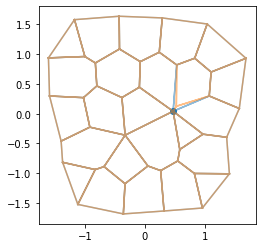

In [11]:
#sheet = bck.copy()
max_rank = sheet.vert_df['rank'].idxmax()

print("Maximum vertex rank prior to rearangement: ", sheet.vert_df['rank'].max())


fig, ax = sheet_view(sheet, mode="quick", edge={"alpha": 0.5})
max_rank_vert = sheet.vert_df['rank'].idxmax()

ax.scatter(sheet.vert_df.loc[max_rank_vert, "x"],
           sheet.vert_df.loc[max_rank_vert, "y"])

split_vert(sheet, max_rank_vert)
geom.update_all(sheet)
fig, ax = sheet_view(sheet, mode="quick", ax=ax, edge={"alpha": 0.5})

print("Maximum vertex rank: ", sheet.vert_df['rank'].max())


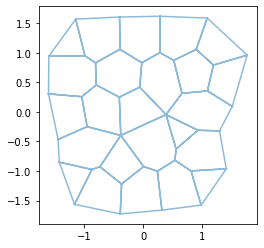

In [12]:
res = solver.find_energy_min(sheet, geom, model)
fig, ax = sheet_view(sheet, mode="quick", edge={"alpha": 0.5})

### Solve repeatedly

Maximum vertex rank prior to rearangement:  5
Maximum vertex rank:  5
Maximum vertex rank:  4
Maximum vertex rank:  4
Maximum vertex rank:  3


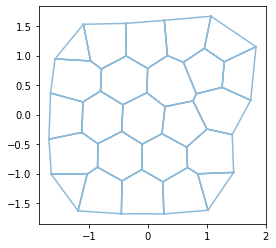

In [13]:
#sheet = bck.copy()
max_rank = sheet.vert_df['rank'].max()
print("Maximum vertex rank prior to rearangement: ", max_rank)

while max_rank > 3:
    max_rank_vert = sheet.vert_df['rank'].idxmax()

    split_vert(sheet, max_rank_vert)
    geom.update_all(sheet)

    res = solver.find_energy_min(sheet, geom, model)
    max_rank = sheet.vert_df['rank'].max()

    print("Maximum vertex rank: ", max_rank)

fig, ax = sheet_view(sheet, mode="quick", edge={"alpha": 0.5})

In [14]:
res = solver.find_energy_min(sheet, geom, model)

In [15]:
sheet.validate()

True

### How about in 3D?



In [51]:
from tyssue import MonolayerGeometry as geom

specs = config.geometry.bulk_spec()

sheet = Sheet.planar_sheet_3d('flat', 8, 9, 1, 1, noise=0.1)
to_cut = sheet.cut_out([(-10, 20), (-10, 20), (-10, 10)])
sheet.remove(to_cut, trim_borders=True)
sheet.sanitize(trim_borders=True)


datasets = extrude(sheet.datasets, method='translation')
eptm = Monolayer('mono', datasets, specs)

geom.center(eptm)
geom.update_all(eptm) 



In [52]:
print(eptm.validate())
c4i, c4ii = condition_4i(eptm), condition_4ii(eptm)
set(c4ii.ravel())

True

In [54]:
model = model_factory([
    effectors.CellVolumeElasticity,
    effectors.FaceContractility,
    #effectors.SurfaceTension,
    effectors.LineTension,
    #effectors.CellAreaElasticity
])

## Initial model settings
dyn_specs = {
    "settings": {
        "threshold_length": 1e-3,
    },
    "cell": {
        "prefered_vol": eptm.cell_df.vol.mean(),
        "prefered_area": eptm.cell_df.area.mean(),
        "vol_elasticity": 14.0,
        #"area_elasticity": 1.0,
    },
    "face": {
        #"surface_tension": 1.0,
        "contractility": 1e-2
    },
    "edge": {
        "line_tension": 0.01,
        "ux": 0.0,
        "uy": 0.0,
        "uz": 0.0,
    }
}

## Those settings are set homogenously in the epithelium
eptm.update_specs(dyn_specs, reset=True)
eptm.face_df.loc[eptm.lateral_faces, 'contractility'] /= 2

solver = QSSolver(with_t1=False, with_t3=False)
res = solver.find_energy_min(eptm, geom, model)
eptm.vert_df['rank'] = eptm.edge_df.groupby('srce').size()

ipv.clear()
eptm.face_df["visible"] =True
fig, mesh = sheet_view(
    eptm,
    mode='3D',
    face={
        "visible": True,
        "color": eptm.face_df.area
    }
)


ipv.show()

Reseting column ux of the edge dataset with new specs
Reseting column uy of the edge dataset with new specs
Reseting column uz of the edge dataset with new specs


In [55]:
eptm.vert_df['rank'].max()

9

In [56]:
eptm.validate()

True

In [58]:

center_edge = eptm.edge_df.query('segment == "apical"').eval("sx**2 + sy**2").idxmin()
merge_vertices(eptm, center_edge)
geom.update_all(eptm)

fig, ax = sheet_view(eptm, mode="quick", ax=ax, edge={"alpha": 0.5})

print("Maximum vertex rank: ", eptm.vert_df['rank'].max())

ipv.clear()
eptm.face_df["visible"] = eptm.face_df['segment'] == "lateral"
fig, mesh = sheet_view(
    eptm,
    mode='3D',
    face={
        "visible": True,
        "color": eptm.face_df.area
    }
)


ipv.show()

Maximum vertex rank:  14


In [60]:
print(eptm.validate())
c4i, c4ii = condition_4i(eptm), condition_4ii(eptm)
set(c4ii.ravel())

True


set()

In [61]:
eptm.vert_df['rank'].idxmax()

60

In [62]:
bck = eptm.copy()


In [30]:
from tyssue.core.sheet import get_opposite

from tyssue.generation import single_cell
from tyssue.core.objects import _is_closed_cell
from tyssue.topology import condition_4i, condition_4ii

sing_cell = single_cell(eptm, 46)
sing_cell.edge_df.drop(sing_cell.edge_df.query('face == 0').index, axis=0, inplace=True)
sing_cell.face_df.drop(0, axis=0, inplace=True)
sing_cell.reset_index()
sing_cell.reset_topo()
print(sing_cell.Nf)



7


In [124]:
def close_cell(eptm, cell):
    eptm.face_df = eptm.face_df.append(
        eptm.face_df.iloc[0], ignore_index=True)

    new_face = eptm.face_df.index[-1]
    
    face_edges = eptm.edge_df[eptm.edge_df["cell"] == cell]
    oppo = get_opposite(face_edges)
    new_edges = face_edges[oppo == -1].copy()
    if not new_edges.shape[0]:
        return 0
    print("closing cell", cell)
    new_edges[["srce", "trgt"]] = new_edges[["trgt", "srce"]]
    new_edges['face'] = new_face
    new_edges.index = new_edges.index + sing_cell.edge_df.index.max()
    eptm.edge_df = eptm.edge_df.append(new_edges, ignore_index=False)

    eptm.reset_index()
    eptm.reset_topo()
    return 0
    

def split_vert_bulk(eptm, vert, epsilon=0.1):
    
    all_edges = eptm.edge_df[
        (eptm.edge_df["trgt"] == vert)
        | (eptm.edge_df["srce"] == vert)
    ]
    
    # choose a triangle
    edge = np.random.choice(all_edges.query('segment=="apical"').index)
    face = eptm.edge_df.loc[edge, "face"]
    # Get all the edges bordering this triangle
    face_eges = eptm.edge_df.query(f'face == {face}')
    print("face", face)
    prev_vs = face_eges[face_eges["trgt"] == vert]["srce"]
    next_vs = face_eges[face_eges["srce"] == vert]["trgt"]
    
    connected = all_edges[
        all_edges["trgt"].isin(next_vs)
        | all_edges["srce"].isin(prev_vs)
        | all_edges["srce"].isin(next_vs)
        | all_edges["trgt"].isin(prev_vs)
    ]
    
    # Add a vertex
    eptm.vert_df = eptm.vert_df.append(
        eptm.vert_df.loc[vert], ignore_index=True)
    new_vert = eptm.vert_df.index[-1]
    
    # Move it towards the face center
    r_ia = (eptm.face_df.loc[face, eptm.coords] - eptm.vert_df.loc[vert, eptm.coords])
    eptm.vert_df.loc[new_vert, eptm.coords] += r_ia * epsilon / np.linalg.norm(r_ia)
    

    # Rewire for all faces with at least one connected edge
    connected_faces = connected['face'].unique()
    connected_fe = all_edges[all_edges['face'].isin(connected_faces)]
    
    eptm.edge_df.loc[connected_fe.index] = connected_fe.replace(
        {"srce": vert, "trgt": vert}, new_vert
    )
    

    for face in all_edges["face"].unique():
        close_face(eptm, face)
        
    for cell in all_edges["cell"]:
        close_cell(eptm, face)
    eptm.reset_index()
    eptm.reset_topo()
    eptm.vert_df['rank'] = eptm.edge_df.groupby('srce').size()


In [130]:
eptm = bck.copy()
vert = eptm.edge_df.query('segment == "apical"').groupby('srce').size().idxmax()
#split_vert_bulk(eptm, vert, epsilon=0.2)

In [126]:
print(eptm.validate())
c4i, c4ii = condition_4i(eptm), condition_4ii(eptm)
set(c4ii.ravel())

False


set()

In [128]:
geom.update_all(eptm)

In [129]:
ipv.clear()
eptm.face_df["visible"] = eptm.face_df.eval('(x**2 + y**2) < 1')
eptm.face_df.loc[set(c4ii.ravel()), "visible"] = True
fig, mesh = sheet_view(
    eptm,
    mode='3D',
    face={
        "visible": True,
        "color": eptm.face_df.area
    }
)


ipv.show()

In [45]:
ipv.clear()
eptm.face_df["visible"] = False
eptm.face_df.loc[set(c4ii.ravel()), "visible"] = True
fig, mesh = sheet_view(
    eptm,
    mode='3D',
    face={
        "visible": True,
        "color": eptm.face_df.area
    }
)


ipv.show()

In [162]:

ipv.clear()

ipv.scatter(
    x=eptm.vert_df.loc[[0, vert], "x"],
    y=eptm.vert_df.loc[[0, vert], "y"],
    z=eptm.vert_df.loc[[0, vert], "z"],
)

eptm = bck.copy()
epsilon = 0.3

all_edges = eptm.edge_df[
    (eptm.edge_df["trgt"] == vert)
    | (eptm.edge_df["srce"] == vert)
]

# choose a terahedron
edge = np.random.choice(all_edges.query('segment=="apical"').index)
face = eptm.edge_df.loc[edge, "face"]
cell = eptm.edge_df.loc[edge, "cell"]
# Get all the edges bordering this triangle
face_eges = eptm.edge_df.query(f'face == {face}')
cell_eges = eptm.edge_df.query(f'cell == {cell}')

print("face", face)
# prev_vs = face_eges[face_eges["trgt"] == vert]["srce"]
# next_vs = face_eges[face_eges["srce"] == vert]["trgt"]
prev_vs = cell_eges[cell_eges["trgt"] == vert]["srce"]
next_vs = cell_eges[cell_eges["srce"] == vert]["trgt"]


connected = all_edges[
    all_edges["trgt"].isin(next_vs)
    | all_edges["srce"].isin(prev_vs)
    | all_edges["srce"].isin(next_vs)
    | all_edges["trgt"].isin(prev_vs)
]

# Add a vertex
eptm.vert_df = eptm.vert_df.append(
    eptm.vert_df.loc[vert], ignore_index=True)
new_vert = eptm.vert_df.index[-1]

# Move it towards the face center
r_ia = (eptm.face_df.loc[face, eptm.coords] - eptm.vert_df.loc[vert, eptm.coords])
eptm.vert_df.loc[new_vert, eptm.coords] += r_ia * epsilon / np.linalg.norm(r_ia)


# Rewire for all faces with at least one connected edge
connected_faces = connected['face'].unique()

#connected_fe = eptm.edge_df[eptm.edge_df['face'].isin(connected_faces)]
# eptm.edge_df.loc[connected_fe.index] = connected_fe.replace(
#     {"srce": vert, "trgt": vert}, new_vert
# )

eptm.edge_df.loc[connected.index] = connected.replace(
    {"srce": vert, "trgt": vert}, new_vert
)


for face in all_edges["face"].unique():
    close_face(eptm, face)

# for cell in all_edges["cell"]:
#     close_cell(eptm, face)
# eptm.reset_index()
# eptm.reset_topo()
# eptm.vert_df['rank'] = eptm.edge_df.groupby('srce').size()





geom.update_all(eptm)
eptm.face_df["visible"] = False
eptm.face_df.loc[connected_faces, "visible"] = True
fig, mesh = sheet_view(
    eptm,
    mode='3D',
    face={
        "visible": True,
        "color": eptm.face_df.area
    }
)


ipv.show()

face 32


In [163]:
eptm.validate()

True

In [164]:
print(eptm.validate())
c4i, c4ii = condition_4i(eptm), condition_4ii(eptm)
set(c4ii.ravel())

True


set()